   # Validação de Dados Modelados com Observados

Carregar arquivos para comparar dados monitorados com séries modelada (arquivos combine)

In [10]:
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import utm
import seaborn as sns
import datetime as dt
from bisect import bisect_left
import math
%matplotlib inline

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before


## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem o arquivo da estação e nomes de rodadas.

In [26]:
directory = str('D:/Mestrado/1.Resultados/QualidadedoAr/')
wrfdir = str('D:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = 'd04_1km'
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
periodo = ['Verão', 'Inverno']

moded = ['-','-20I','-20T','-20I-20T']
modnames = ['ED', 'ED-20I','ED-20T','ED-20I-20T']
modpt = ['_PT_ED-100I','_PT-20_ED-100I', '_PT_ED-100I-20T', '_PT-20_ED-100I-20T']
modptnames = ['PT_ED-100I', 'PT-20_ED-100I','PT_ED-100I-20T','PT-20_ED-100I-20T']
shapes = ['pirashape','RMSP']

spinup = 48
run_len = 24*7
gmt = 3

date_index = 0

In [27]:
#DADOS ESTACAO
estacao     = 'PIRACICABA (A)'
estlat,estlon = utm.to_latlon(easting=227797, northing=7487124, zone_letter='k', zone_number=23)
est = pd.read_csv(directory+'piracicaba.csv', delimiter=';')
#est['Hora'] = est['Hora'].apply(lambda x: '24:00' if x == '24:00:00' else x)
est['Hora'] = est['Hora'].apply(lambda x: dt.timedelta(hours=float(x[:2])))
est['Data'] = est['Data'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y'))
est['Data'] += est['Hora']
est.drop(columns=['Unnamed: 0','Hora','wind_dir','wind_dir_avg','temp','ur','wind_vel'], inplace=True)
est.set_index('Data', inplace=True)

## Abrir arquivos COMBINE ACONC e DEP

In [28]:
aconc = []
for m in moded:
    aconc.append(xr.open_dataset(directory+mes[date_index]+'.'+grade+m+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                        mes[date_index]+'_'+data[date_index]+'.nc'))
for m in modpt:
    aconc.append(xr.open_dataset(directory+mes[date_index]+'.'+grade+m+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                        mes[date_index]+'_'+data[date_index]+'.nc'))

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(LAY=0)

## Abrir arquivo WRF para buscar valores de LAT / LON

In [29]:
nc_wrf = Dataset(wrfdir+'arqWRF/'+mes[0]+'/wrf_fnl_pira_pedruzzi2016_nudge_'+
                 mes[0]+'/wrfout_'+grade[:3]+'_2015-'+datawrf[0]+'_00%3A00%3A00')

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [30]:
# DATAS
dates = []
dates = [dt.datetime.strptime(str(aconc[0].attrs['SDATE']),'%Y%j')]
for i in range(1,aconc[0].dims['TSTEP']):
    dates.append(dates[0]+dt.timedelta(hours=i))
    
# LATITUDE
# LONGITUDE
croplat = int((nc_wrf.dimensions['south_north'].size-aconc[0].dims['ROW'])/2)
croplon = int((nc_wrf.dimensions['south_north'].size-aconc[0].dims['ROW'])/2)
lats      = nc_wrf.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
longs     = nc_wrf.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# COORDENADAS PARA POSICIONAR ESTACAO
if (estlat > np.amin(lats) and
    estlat < np.amax(lats) and
    estlon > np.amin(longs)and
    estlon < np.amax(longs)):                
    esty     = lats[:,0].tolist().index(takeClosest(lats[:,0],estlat))     #index Lat da estação no domínio
    estx     = longs[0,:].tolist().index(takeClosest(longs[0,:],estlon))   #index Lat da estação no domínio

# PLOT CORNERS
llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=aconc[0].dims['ROW'])
coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=aconc[0].dims['COL'])

# ADJUSTMENTS
for a in aconc:
    a.coords['TSTEP'] = dates
    a.coords['ROW'] = coordlat
    a.coords['COL'] = coordlon
    a.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in a.variables:
        if 'units' in a.variables[var].attrs:
            if a.variables[var].attrs['units'].split() != []:
                a.variables[var].attrs['units'] = a.variables[var].attrs['units'].split()[0]

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(TSTEP=slice(spinup,spinup+run_len))
    aconc[i].coords['TSTEP'] -= pd.Timedelta(gmt,'h')
weekd=[]
for d in aconc[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Weekday')
    else:
        weekd.append('Weekend')

## Figuras - PlotGeo

### Material Particulado

In [ ]:
## Plotar 4 figuras (ED Verao e Inverno, PT Verao e Inverno)
modplot = mod

moded = ['-','-20I','-20T','-20I-20T']
modnames = ['ED', 'ED-20I','ED-20T','ED-20I-20T']
modpt = ['_PT_ED-100I','_PT-20_ED-100I', '_PT_ED-100I-20T', '_PT-20_ED-100I-20T']
modptnames = ['PT_ED-100I', 'PT-20_ED-100I','PT_ED-100I-20T','PT-20_ED-100I-20T']

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-48.16735839843751,-23.166358947753906,-47.176361083984375,-22.254440307617188&bboxSR=4326&imageSR=4326&size=400,368&dpi=500&format=png32&f=image


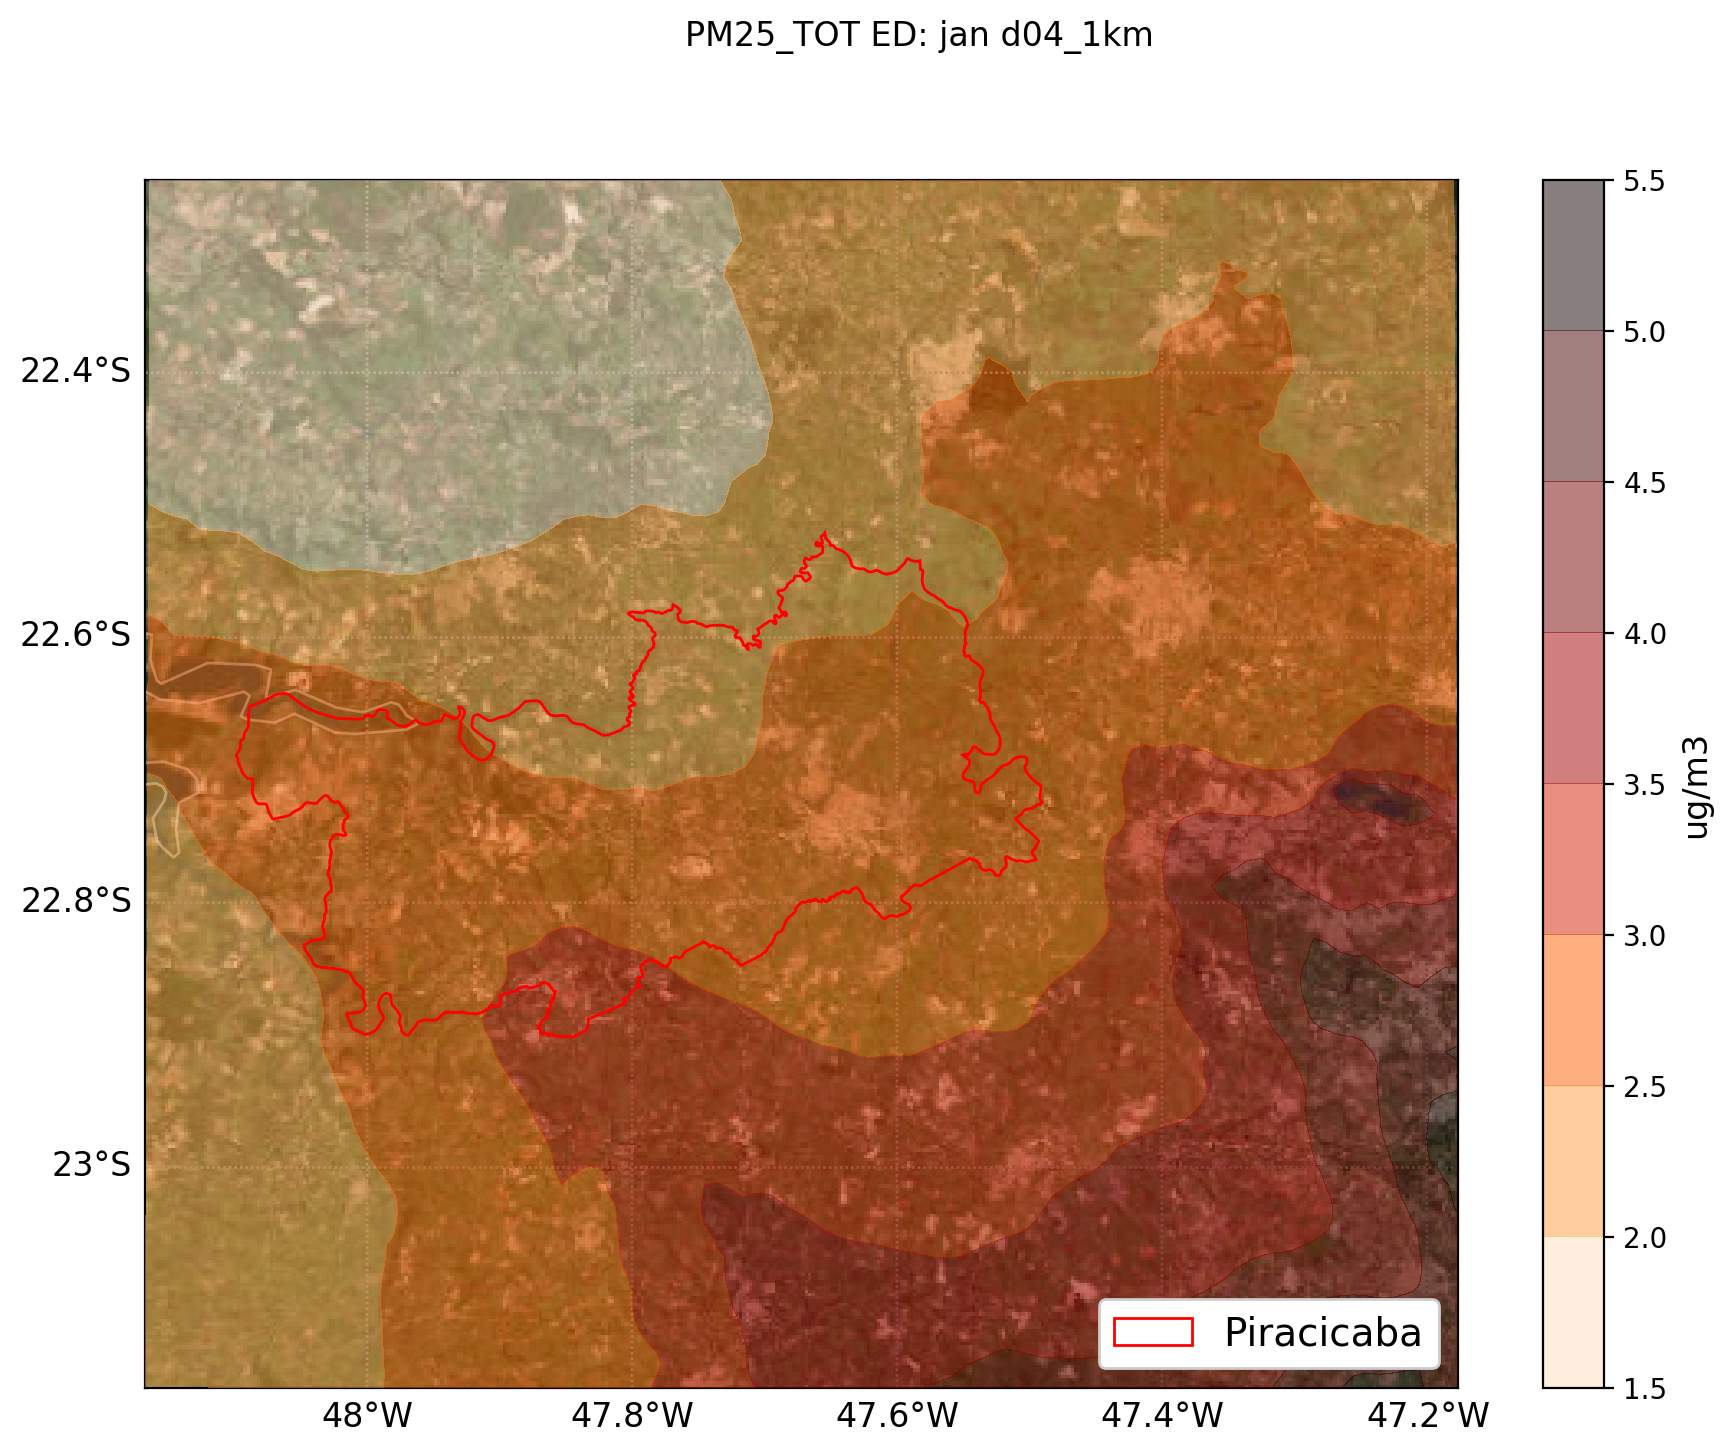

In [33]:
param = 'PM25_TOT'
mesplt = mes[date_index]
gradeplt = grade
modplot = aconc[0]
name = modnames[0]

d = np.squeeze(modplot[param])[:,:,:].mean(dim='TSTEP')
d = np.ma.array(d,mask=d<0)

# PLOT COLORMAP
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11,8), dpi=200)
fig.suptitle(param+' '+name+': '+mesplt+' '+gradeplt, fontsize=12)
m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes)           
paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.gist_heat_r,
                        alpha=0.5,
                        #vmin=0,
                        #vmax=int(np.ceil(modplot[param][:,0,:,:].max())),
                        #levels=np.linspace(0,modplot[param][:,0,:,:].max(),num=1000),
                        zorder=5)
## COLORBAR
cbar = fig.colorbar(paramplot, ax=axes) # Plot Colorbar
cbar.set_label(modplot.variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 10)

# ADD FEATURES
# Draw some map elements on the map
m.drawcoastlines(linewidth=1.0, color=[1,1,1,0.5], zorder=1)
m.drawstates(linewidth=1.0, color='w', zorder=1)
m.drawcountries(linewidth=1.0, color='w', zorder=1)
#m.bluemarble()
#m.shadedrelief()
#m.drawrivers(color='blue')
m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[6], dpi=500, verbose= True)

## PLOT SHAPEFILES
#for s in shapes:
#    map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile

# ADD SHAPES
shps = ['Piracicaba']
colors= {'Piracicaba':'red', 'RMSP':'purple'}
shapes = {}
#### SHAPE 1
m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
shapes[shps[0]] = p
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
for shp in shps:
    plt.gca().add_artist(shapes[shp])        
#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
plt.legend(handles=handles, labels=labels, framealpha=1., loc='lower right', fontsize=14)

plt.show()


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-48.16735839843751,-23.166358947753906,-47.176361083984375,-22.254440307617188&bboxSR=4326&imageSR=4326&size=400,368&dpi=500&format=png32&f=image


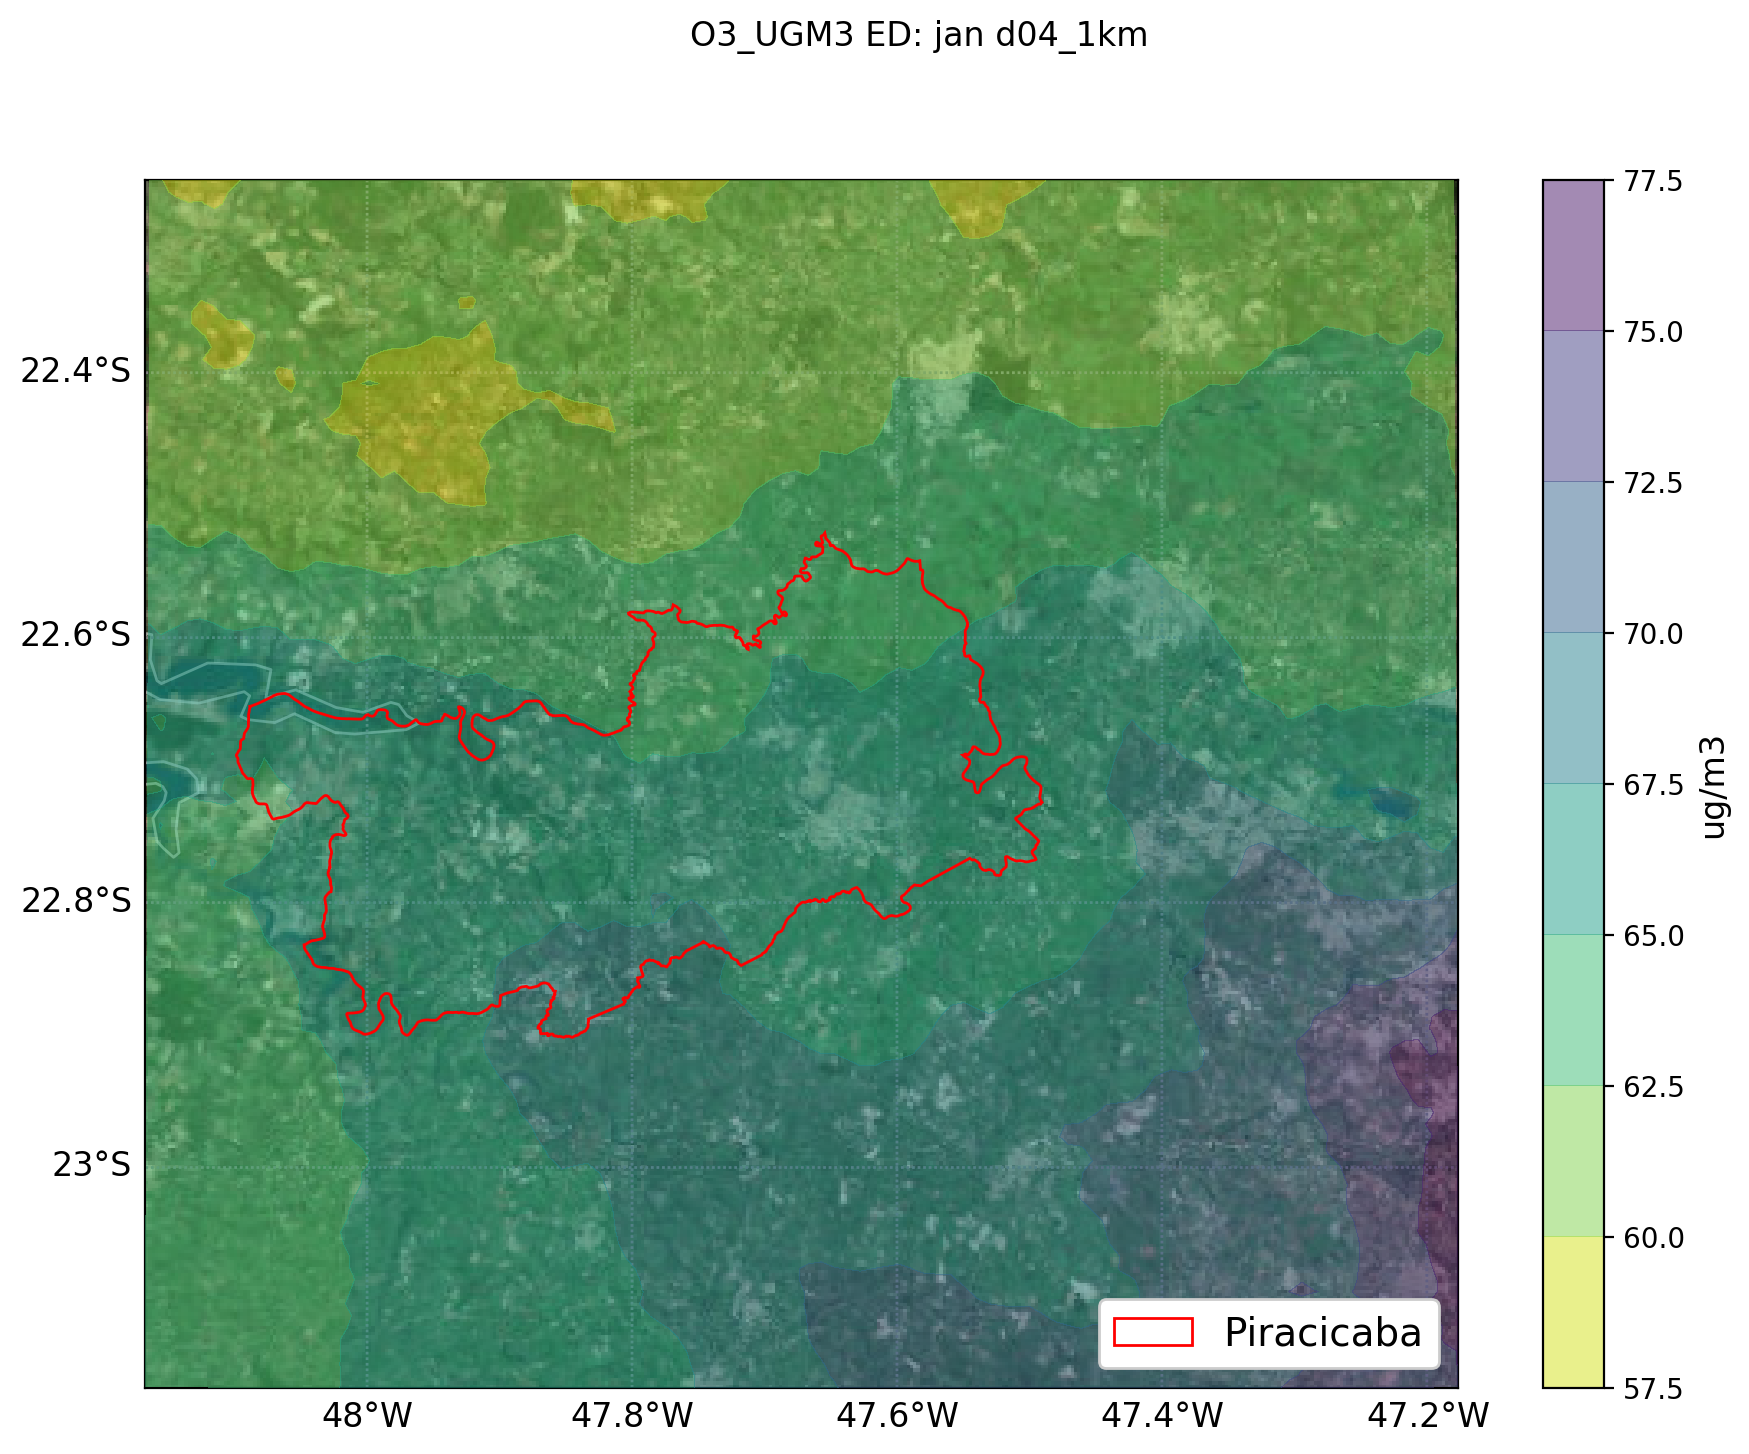

In [34]:
param = 'O3_UGM3'
mesplt = mes[date_index]
gradeplt = grade
modplot = aconc[0]
name = modnames[0]

d = np.squeeze(modplot[param])[:,:,:].mean(dim='TSTEP')
d = np.ma.array(d,mask=d<0)

# PLOT COLORMAP
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11,8), dpi=200)
fig.suptitle(param+' '+name+': '+mesplt+' '+gradeplt, fontsize=12)
m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes)           
paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.viridis_r,
                        alpha=0.5,
                        #vmin=0,
                        #vmax=int(np.ceil(modplot[param][:,0,:,:].max())),
                        #levels=np.linspace(0,modplot[param][:,0,:,:].max(),num=1000),
                        zorder=5)
## COLORBAR
cbar = fig.colorbar(paramplot, ax=axes) # Plot Colorbar
cbar.set_label(modplot.variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 10)

# ADD FEATURES
# Draw some map elements on the map
m.drawcoastlines(linewidth=1.0, color=[1,1,1,0.5], zorder=1)
m.drawstates(linewidth=1.0, color='w', zorder=1)
m.drawcountries(linewidth=1.0, color='w', zorder=1)
#m.bluemarble()
#m.shadedrelief()
#m.drawrivers(color='blue')
m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[6], dpi=500, verbose= True)

## PLOT SHAPEFILES
#for s in shapes:
#    map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile

# ADD SHAPES
shps = ['Piracicaba']
colors= {'Piracicaba':'red', 'RMSP':'purple'}
shapes = {}
#### SHAPE 1
m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
shapes[shps[0]] = p
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
for shp in shps:
    plt.gca().add_artist(shapes[shp])        
#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
plt.legend(handles=handles, labels=labels, framealpha=1., loc='lower right', fontsize=14)

plt.show()